In [1]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import ensemble

In [3]:
#Import dataset
trimmed2018 = pd.read_csv('cdc2018trimmed.csv')
# csv2018 = pd.read_csv('CSV2018.csv')
# dsample = 

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
dsample = trimmed2018

In [4]:
#Downsample function, thanks Bettina and Aron!
def downsample_df (df):

    '''
    Remove undefined information on NICU admissions (AB_NICU == 'U'),
    create a binary target vector, and create a "balanced" dataframe
    with all NICU admissions and matching numbers of randomly selected non-NICU admissions.
    '''

    import pandas as pd
    import numpy as np

    # remove unknown class from df
    df_no_unknown = df[df['AB_NICU'].isin(['Y', 'N'])]

    # Create binary target vector, NICU = yes classified as class 0
    df_y_n = np.where((df_no_unknown['AB_NICU'] == 'Y'), 0, 1)

    # Get indicies of each class' observations
    index_class0 = np.where(df_y_n == 0)[0]
    index_class1 = np.where(df_y_n == 1)[0]

    # Get numbers of observations in class 0
    n_class0 = len(index_class0)

    # Randomly sample the same number of observations from class 1 as in class 0, without replacement
    np.random.seed(0)
    index_class1_downsampled = np.random.choice(index_class1, size=n_class0, replace=False)

    # Create dataframes for NICU and downsampled non-NICU
    df_defect = df_no_unknown.iloc[index_class0]
    df_adj_NONdefect = df_no_unknown.iloc[index_class1_downsampled]

    # Append into 1 dataframe
    df_downsampled = df_defect.append(df_adj_NONdefect)

    return df_downsampled

In [6]:
#Downsampled
dsample = downsample_df(dsample)

In [ ]:
def create_reduced_df (df, list_to_drop):

    '''
    Function to choose columns from dataframe for label encoding. Takes the data frame and the columns to drop
    as a list.
    '''

    import pandas as pd
    import numpy as np

    # create list of flags, territory info and imputed info likely to be dropped together
    flags = list(filter(lambda i: re.search('\AF_',i) , df.columns))
    territory_info = ['OCTERR','OCNTYFIPS', 'OCNTYPOP', 'MBCNTRY', 'MRCNTRY', 'MRTERR', 'RCNTY', 'RCNTY_POP', 'RCNTY_POP',
                 'RCITY_POP', 'RECTYPE']
    imputed_info = ['MAGE_IMPFLG', 'MAGE_REPFLG', 'MRACEIMP','MAR_IMP', 'FAGERPT_FLG', 'IMP_PLUR', 'IMP_SEX',
                'COMPGST_IMP', 'OBGEST_FLG', 'LMPUSED']

    # create a copy of dataframe
    df2 = df.copy()

    # compare columns in case they have already been dropped in the input df
    

    # drop columns
    for feature in list_to_drop:
        #if ~feature.isin(df2.colunms):
        #    except ValueError:
        #    print("Column name does not exist")
        elif feature == 'flag':
            df2.drop(flags, inplace = True, axis=1)
        elif feature == 'territory':
            df2.drop(territory_info, inplace = True, axis=1)
        elif feature == 'imputed':
            df2.drop(imputed_info, inplace = True, axis=1)
        else:
            df2.drop(feature, inplace = True, axis=1)

    return df2

In [ ]:
dsample = create_reduced_df(dsample)

In [7]:
#LabelEncoding Function. Thanks Ira!
def LabelEncoding(dataframe):
    '''
    Function that takes a dataframe and transforms it with label encoding on all the categorical features.
    '''
    
    #create a list using object types since dataframe.dtypes.value_counts() only shows objects and int64
    objlist = list(dataframe.select_dtypes(include=['object']).columns)
    
    #change type then transform column using cat codes
    for col in objlist:
        dataframe[col] = dataframe[col].astype('category')
        dataframe[col] = dataframe[col].cat.codes
    
    return dataframe

In [8]:
#Label Encoded
dsample = LabelEncoding(dsample)

In [21]:
def targetchoice(column,dataframe):
    '''
    Takes a column and a dataframe, returns four values for;
    x_train, X_test, y_train, and y_test
    '''
    #Cutting the data and target dataframes
    sample_data = dataframe.loc[:, dsample.columns != column ]
    sample_target = dataframe.loc[:,column]
    
    #assigning to variables
    X_train, X_test, y_train, y_test = train_test_split(sample_data, sample_target, test_size=0.2, random_state=0)
    
    #appending to a list to return for multi-assignment
    varlist = []
    varlist.append(X_train)
    varlist.append(X_test)
    varlist.append(y_train)
    varlist.append(y_test)
    return varlist

#format is "X_train, X_test, y_train, y_test = targetchoice()"

In [22]:
X_train, X_test, y_train, y_test = targetchoice('AB_NICU',dsample)

In [8]:
#RANDOM FOREST INITIAL FIT-
randomForest = ensemble.RandomForestClassifier()
randomForest.set_params(random_state=0)
randomForest.fit(X_train, y_train) 
print("The training error is: %.5f" % (1 - randomForest.score(X_train, y_train)))
print("The test     error is: %.5f" % (1 - randomForest.score(X_test, y_test)))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The training error is: 0.01301
The test     error is: 0.16458


In [19]:
# set the parameter grid
grid_para_forest = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 16),
    'n_estimators': range(10, 50, 30)
}
# grid search
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring='accuracy', cv=5, n_jobs=-1,)
%time grid_search_forest.fit(X_train, y_train)

CPU times: user 1min 21s, sys: 2.96 s, total: 1min 24s
Wall time: 56min 35s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': range(1, 16), 'n_estimators': range(10, 50, 30)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [20]:
# Best Params so far: {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 40}
# 0.8431166186317793
print(grid_search_forest.best_params_)
grid_search_forest.best_score_

{'criterion': 'gini', 'max_depth': 15, 'n_estimators': 40}


0.8431166186317793

In [21]:
# get the training/test errors
print("The training error is: %.5f" % (1 - grid_search_forest.best_estimator_.score(X_train, y_train)))
print("The test     error is: %.5f" % (1 - grid_search_forest.best_estimator_.score(X_test, y_test)))

The training error is: 0.15095
The test     error is: 0.15773


In [56]:
#list of feature importance
feature_importance = list(zip(dsample.columns, randomForest.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
[i for (i, j) in feature_sort[0:10]]

[b'BWTR12',
 b'GESTREC10',
 b'AB_AVEN1',
 b'AB_SURF',
 b'APGAR5',
 b'DOB_TT',
 b'PREVIS',
 b'DOB_MM',
 b'CA_HYPO',
 b'LD_STER']

In [ ]:
#Sorting feature importance
sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)

Text(0.5, 1.0, 'feature importance')

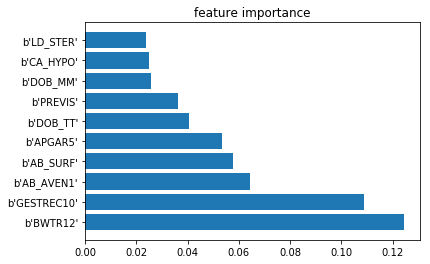

In [58]:
# Plot
features_top10 = sorted_features[:10]
featureNames, featureScores = zip(*list(features_top10))
plt.barh(range(len(featureScores)), featureScores, tick_label=featureNames)
plt.title('feature importance')


In [35]:
#Thanks Drucila!
feature_importance = 100.0 * (randomForest.feature_importances_ / randomForest.feature_importances_.max())
important_features = X_train.columns[feature_importance >= 10]
unimportant_features = X_train.columns[feature_importance < 5]

In [34]:
important_features

Index(['DOB_MM', 'DOB_TT', 'DOB_WK', 'MAGER9', 'MEDUC', 'FAGEREC11', 'FEDUC',
       'ILLB_R11', 'PRECARE', 'PREVIS', 'BMI_R', 'WTGAIN_REC', 'LD_STER',
       'ME_TRIAL', 'APGAR5', 'GESTREC10', 'BWTR12', 'AB_AVEN1', 'AB_AVEN6',
       'AB_ANTI', 'ITRAN'],
      dtype='object')

In [36]:
unimportant_features

Index(['DOB_YY', 'BFACIL3', 'PRIORDEAD', 'CIG0_R', 'CIG1_R', 'CIG2_R',
       'CIG3_R', 'RF_PDIAB', 'RF_GDIAB', 'RF_PHYPE', 'RF_EHYPE', 'RF_PPTERM',
       'RF_INFTR', 'RF_FEDRG', 'RF_ARTEC', 'RF_CESAR', 'RF_CESARN', 'IP_GON',
       'IP_SYPH', 'IP_CHLAM', 'IP_HEPB', 'IP_HEPC', 'OB_ECVS', 'LD_INDL',
       'LD_AUGM', 'LD_ANES', 'ME_PRES', 'MM_MTR', 'MM_PLAC', 'MM_RUPT',
       'MM_UHYST', 'MM_AICU', 'MTRAN', 'DPLURAL', 'AB_SURF', 'AB_SEIZ',
       'CA_ANEN', 'CA_MNSB', 'CA_CCHD', 'CA_CDH', 'CA_OMPH', 'CA_GAST',
       'CA_LIMB', 'CA_CLEFT', 'CA_CLPAL', 'CA_DOWN', 'CA_DISOR', 'CA_HYPO',
       'ILIVE'],
      dtype='object')

In [59]:
sorted_features

[(b'BWTR12', 0.12441732),
 (b'GESTREC10', 0.10888971),
 (b'AB_AVEN1', 0.06423038),
 (b'AB_SURF', 0.05783656),
 (b'APGAR5', 0.05359019),
 (b'DOB_TT', 0.04049833),
 (b'PREVIS', 0.03620637),
 (b'DOB_MM', 0.02591503),
 (b'CA_HYPO', 0.02485286),
 (b'LD_STER', 0.02371669),
 (b'DOB_WK', 0.02125367),
 (b'MEDUC', 0.01949017),
 (b'PRECARE', 0.01898294),
 (b'WTGAIN_REC', 0.01813865),
 (b'AB_AVEN6', 0.01812059),
 (b'FEDUC', 0.01790124),
 (b'FAGEREC11', 0.01789862),
 (b'BMI_R', 0.01724135),
 (b'MAGER9', 0.01639423),
 (b'ME_TRIAL', 0.01562728),
 (b'ILLB_R11', 0.01474588),
 (b'TBO_REC', 0.0120014),
 (b'FRACEHISP', 0.01169319),
 (b'MRACEHISP', 0.01167114),
 (b'ME_ROUT', 0.01012356),
 (b'LD_CHOR', 0.00971956),
 (b'APGAR10', 0.00937809),
 (b'PAY_REC', 0.00912643),
 (b'PRIORTERM', 0.00912234),
 (b'PRIORLIVE', 0.00876588),
 (b'LBO_REC', 0.00868713),
 (b'RESTATUS', 0.00850041),
 (b'MAR_P', 0.00816675),
 (b'ILIVE', 0.00745107),
 (b'RF_GHYPE', 0.00713676),
 (b'ATTEND', 0.00711052),
 (b'DMAR', 0.00706267),
 (